<a href="https://colab.research.google.com/github/zmunilla/TFM/blob/main/7_Siamese_Contrastive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-CONECTAMOS A DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2-CARGAMOS LIBRERÍAS

In [ ]:
import os
import shutil
import random
from pathlib import Path
from math import floor
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import pickle
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
from collections import defaultdict
from tqdm import tqdm

3-FUNCION CREAR PARES AL VUELO CON 30% POSITIVOS Y 70% NEGATIVOS

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_images = {
            cls: os.listdir(os.path.join(root_dir, cls))
            for cls in self.classes
        }

        # Filtramos clases vacías
        self.classes = [cls for cls in self.classes if len(self.class_to_images[cls]) >= 1]

    def __len__(self):
        return 5000

    def __getitem__(self, idx):
        # 30% positivos, 70% negativos
        same_class = random.random() < 0.3

        class1 = random.choice(self.classes)

        if same_class:
            class2 = class1
            while len(self.class_to_images[class1]) < 2:
                class1 = random.choice(self.classes)
                class2 = class1
        else:
            class2 = random.choice([c for c in self.classes if c != class1])

        img1_name = random.choice(self.class_to_images[class1])

        if same_class:
            img2_name = random.choice([img for img in self.class_to_images[class2] if img != img1_name])
        else:
            img2_name = random.choice(self.class_to_images[class2])

        img1_path = os.path.join(self.root_dir, class1, img1_name)
        img2_path = os.path.join(self.root_dir, class2, img2_name)

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.tensor(1.0 if same_class else 0.0, dtype=torch.float32)
        return img1, img2, label


4. FUNCION PARA REDIMENSIONAR SIN DEFORMAR

In [ ]:

from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

#los bordes de las imágenes que hay que rellenar para completar el tamaño se rellenan
#con color negro

5. FUNCIONES DE TRANSFORMACIÓN

In [ ]:
resize_pad = ResizeWithPadding((224, 224)) #redimensionamos a 224x224

train_transform = transforms.Compose([
    resize_pad,
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform = test_transform #para usar luego con las nuevas imágenes de prueba

6. CARGAR DATOS

In [ ]:
train_dataset = SiameseDataset("/content/drive/MyDrive/TFM/Cat_dataset/left_2/train", transform=train_transform)
test_dataset = SiameseDataset("/content/drive/MyDrive/TFM/Cat_dataset/left_2/test", transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

7-DEFINIR RED SIAMESA USANDO RESNET50 CON VECTOR CARACTERISTICAS DE DIMENSIÓN 512

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        base_model = models.resnet50(weights=True)
        self.feature_extractor = nn.Sequential(
            *list(base_model.children())[:-1], #eliminamos última capa de la red preentrenada
            nn.Flatten(),         #esta capa de aplanamiento pasa de un tensor 3D a 1D
            nn.Linear(2048, 512),  #queremos el vector de embeddings de dimensión 512
            nn.ReLU() #función de activación ReLU
        )

    def forward_once(self, x):
        return self.feature_extractor(x) #función de extracción de embeddings

    def forward(self, x1, x2):
        f1 = self.forward_once(x1) #se aplica de manera "siamesa" a dos imágenes
        f2 = self.forward_once(x2)
        return f1, f2 #devuelve los embeddings


8-DEFINIMOS FUNCIÓN DE PÉRDIDA CONTRASTIVE LOSS

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0): #margin: distancia mínima deseada entre pares negativos
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, p=2)
        loss = label * distance.pow(2) + \ #label 1=mismo id; label 0= distinto id
               (1 - label) * F.relu(self.margin - distance).pow(2)
        return loss.mean()


9-ENTRENAR RED SIAMESA CON CONSTRASTIVE LOSS Y GUARDAR MÉTRICAS

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4) #Usamos optimizador Adam.

best_accuracy = 0.0
best_loss = float('inf')
save_path = '/content/drive/MyDrive/TFM/modelos2/best_siamese_contrastive_10epoc_right.pth'

# Historial de métricas para poder hacer gráficas
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)

        optimizer.zero_grad() #limpiamos gradientes anteriores
        loss.backward() #backpropagation para calcular gradientes
        optimizer.step() #actualiza los pesos del modelo

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

# Evaluación en dataset test (repetimos con dataset test)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            test_loss += loss.item()

            distance = F.pairwise_distance(output1, output2)
            preds = (distance < 0.5).float() #predicción de si las imágenes son del mismi id o no
            correct += (preds == label).sum().item()
            total += label.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    accuracy = correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    if (accuracy > best_accuracy) or (accuracy == best_accuracy and avg_test_loss < best_loss):
        best_accuracy = accuracy
        best_loss = avg_test_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_test_loss,
            'accuracy': accuracy
        }, save_path)
        print(f"--> Mejor modelo guardado en epoch {epoch+1} con Accuracy: {accuracy:.4f} y Loss: {avg_test_loss:.4f}")

#se guarda el modelo con mejor precisión en test y en caso de haber más de uno el
#que tiene menor test loss


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Epoch 1, Train Loss: 0.1701
Epoch 1, Test Loss: 0.1559, Test Accuracy: 0.7882
--> Mejor modelo guardado en epoch 1 con Accuracy: 0.7882 y Loss: 0.1559
Epoch 2, Train Loss: 0.0487
Epoch 2, Test Loss: 0.1380, Test Accuracy: 0.8098
--> Mejor modelo guardado en epoch 2 con Accuracy: 0.8098 y Loss: 0.1380
Epoch 3, Train Loss: 0.0292
Epoch 3, Test Loss: 0.1340, Test Accuracy: 0.8034
Epoch 4, Train Loss: 0.0178
Epoch 4, Test Loss: 0.1387, Test Accuracy: 0.8028
Epoch 5, Train Loss: 0.0128
Epoch 5, Test Loss: 0.1494, Test Accuracy: 0.8080
Epoch 6, Train Loss: 0.0090
Epoch 6, Test Loss: 0.1345, Test Accuracy: 0.8146
--> Mejor modelo guardado en epoch 6 con Accuracy: 0.8146 y Loss: 0.1345
Epoch 7, Train Loss: 0.0062
Epoch 7, Test Loss: 0.1277, Test Accuracy: 0.7890
Epoch 8, Train Loss: 0.0049
Epoch 8, Test Loss: 0.1394, Test Accuracy: 0.8352
--> Mejor modelo guardado en epoch 8 con Accuracy: 0.8352 y Loss: 0.1394
Epoch 9, Train Loss: 0.0097
Epoch 9, Test Loss: 0.1510, Test Accuracy: 0.8112
Epoch 

**GUARDAR MÉTRICAS EN CSV**

In [ ]:
# Guardar métricas como csv para gráficas y análisis posteriores

history = pd.DataFrame({
    "epoch": list(range(1, len(train_losses) + 1)),
    "train_loss": train_losses,
    "test_loss": test_losses,
    "test_accuracy": test_accuracies
})
history.to_csv("/content/drive/MyDrive/TFM/modelos2/training_metrics_contrast10_right.csv", index=False)
print("Historial guardado en CSV.")


Historial guardado en CSV.


**CARGAR MÉTRICAS**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar las métricas desde el archivo CSV
metrics_path = "/content/drive/MyDrive/TFM/modelos2/training_metrics_contrast10_right.csv"
history = pd.read_csv(metrics_path)

# Extraer columnas como listas

epochs = list(history["epoch"])
train_losses = list(history["train_loss"])
test_losses = list(history["test_loss"])
test_accuracies = list(history["test_accuracy"])

**HACER GRÁFICOS**

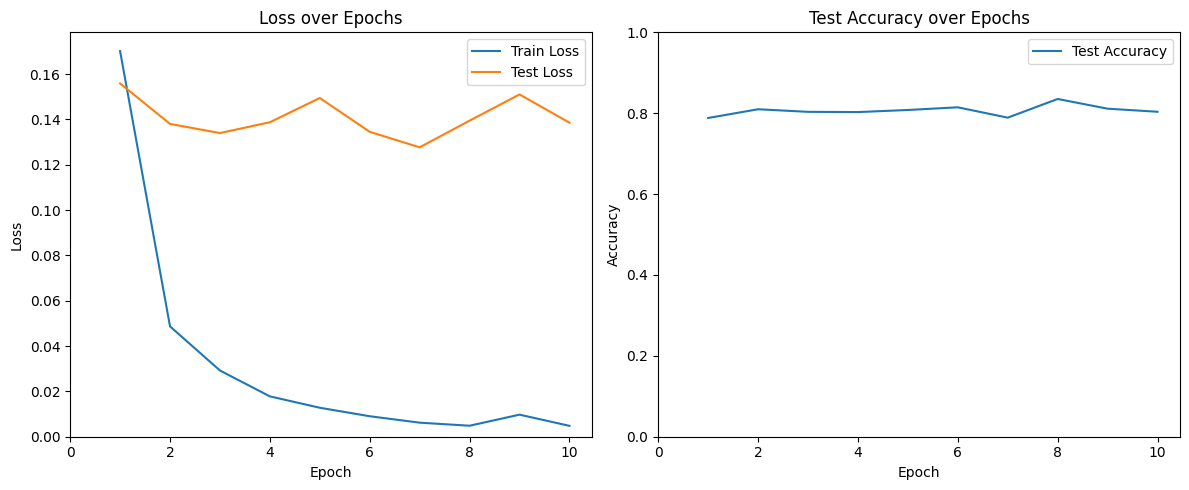

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.xlim(0)
plt.ylim(0)

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.ylim(0, 1)
plt.xlim(0)
plt.legend()

plt.tight_layout()
plt.show()


**CARGAR MODELO PARA HACER PRUEBAS**

In [ ]:
#CARGAMOS MODELO SI ES NECESARIO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)

# Cargar pesos entrenados
checkpoint = torch.load("/content/drive/MyDrive/TFM/modelos2/best_siamese_contrastive_10epoc_left.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


SiameseNetwork(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

10. FUNCIÓN PARA CREAR EMBEDDINGS PROMEDIO DEL CATÁLOGO INCLUYENDO UNA IMAGEN DE CADA CLASE

In [ ]:
#Incluye ruta a imagenes en el catalogo de embeddings

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
from collections import defaultdict

def compute_average_embeddings(model, dataset_path, transform, device,
                               save_path="/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_im.pkl"):
    model.eval()
    embeddings_per_class = defaultdict(list)
    image_paths_per_class = defaultdict(list)

    # Dataset estructurado como ImageFolder
    dataset = ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Guardar también rutas originales
    original_image_paths = [path for path, _ in dataset.samples]

    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(loader, desc="Extrayendo embeddings")):
            images = images.to(device)
            embeddings = model.forward_once(images)  # Rama única de red siamesa

            for j, (emb, label) in enumerate(zip(embeddings, labels)):
                class_name = dataset.classes[label]
                index_in_dataset = i * loader.batch_size + j
                img_path = original_image_paths[index_in_dataset]

                embeddings_per_class[class_name].append(emb.cpu())
                image_paths_per_class[class_name].append(img_path)

    # Generar el diccionario final con embedding promedio con imagen representativa
    avg_catalog = {}
    for cls in embeddings_per_class:
        avg_emb = torch.stack(embeddings_per_class[cls]).mean(dim=0)
        representative_img_path = image_paths_per_class[cls][0]  # la primera imagen de esa clase
        avg_catalog[cls] = {
            "embedding": avg_emb,
            "image_path": representative_img_path
        }

    # Guardar como pickle
    with open(save_path, 'wb') as f:
        pickle.dump(avg_catalog, f)

    print(f"\n✅ Catálogo de embeddings promedio guardado en: {save_path}")
    return avg_catalog


11. CREACIÓN Y ALMACENAMIENTO EMBEDDINGS DEL CATÁLOGO




In [ ]:
catalog_path = "/content/drive/MyDrive/TFM/Cat_dataset/left_2/train"

avg_embeddings = compute_average_embeddings(
    model=model,
    dataset_path=catalog_path,
    transform=transform,  # usa transform que incluye ResizeWithPadding
    device=device,
    save_path="/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_im.pkl"
)


Extrayendo embeddings: 100%|██████████| 4/4 [01:56<00:00, 29.02s/it]


✅ Catálogo de embeddings promedio guardado en: /content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_im.pkl


12. FUNCIÓN DE REDIMENSIONAR SIN DEFORMAR PARA NUEVAS IMÁGENES (YA USADA ANTES)

In [ ]:
from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size  # (alto, ancho)
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img

In [ ]:
resize_pad = ResizeWithPadding((224, 224))

transform = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

13. USO ALGORTIMO IDENTIFICACIÓN NUEVA IMAGEN USANDO ALGORITMO KNN


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from sklearn.neighbors import NearestNeighbors
import os

#Función creación de embeddings

def get_embedding(model, image_path, transform, device, use_cosine=False):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        embedding = model.forward_once(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0) if use_cosine else embedding

    return embedding.cpu().numpy()

#Función predicción usando k-nearest neighbours

def predict_with_dynamic_knn(image_path, model, transform, catalog_pkl_path, device, k=3, metric='euclidean'):
    # Cargar catálogo
    with open(catalog_pkl_path, "rb") as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])
    image_paths_dict = {c: catalog[c]['image_path'] for c in class_ids}

    # Obtener embedding de la imagen incógnita
    query_embedding = get_embedding(model, image_path, transform, device, use_cosine=(metric == 'cosine')).reshape(1, -1)

    # Construir índice k-NN y buscar
    knn = NearestNeighbors(n_neighbors=k, metric=metric)
    knn.fit(embeddings)
    distances, indices = knn.kneighbors(query_embedding)

    neighbors = [class_ids[i] for i in indices[0]]

    # Mostrar resultados
    print(f"\nTop-{k} predicciones para: {os.path.basename(image_path)}")
    for i, (name, dist) in enumerate(zip(neighbors, distances[0]), 1):
        print(f"{i}. {name} (distancia: {dist:.4f})")

    # Visualización
    fig, axs = plt.subplots(1, k + 1, figsize=(3 * (k + 1), 4))
    query_img = Image.open(image_path).convert('RGB')
    axs[0].imshow(query_img)
    axs[0].axis("off")
    axs[0].set_title("Consulta")

    for i, name in enumerate(neighbors, 1):
        img_path = image_paths_dict.get(name)
        if img_path and os.path.exists(img_path):
            match_img = Image.open(img_path).convert("RGB")
            axs[i].imshow(match_img)
            axs[i].axis("off")
            axs[i].set_title(f"{i}. {name}\nDist: {distances[0][i-1]:.4f}")
        else:
            axs[i].text(0.5, 0.5, "No img", ha='center', va='center')
            axs[i].axis("off")

    plt.tight_layout()
    plt.show()

    return neighbors, distances[0]


14. USO ALGORITMO CON NUEVAS IMÁGENES


Top-3 predicciones para: 039_left.jpg
1. 039_L (distancia: 0.4841)
2. 040_L (distancia: 0.7136)
3. 016_L (distancia: 0.7674)


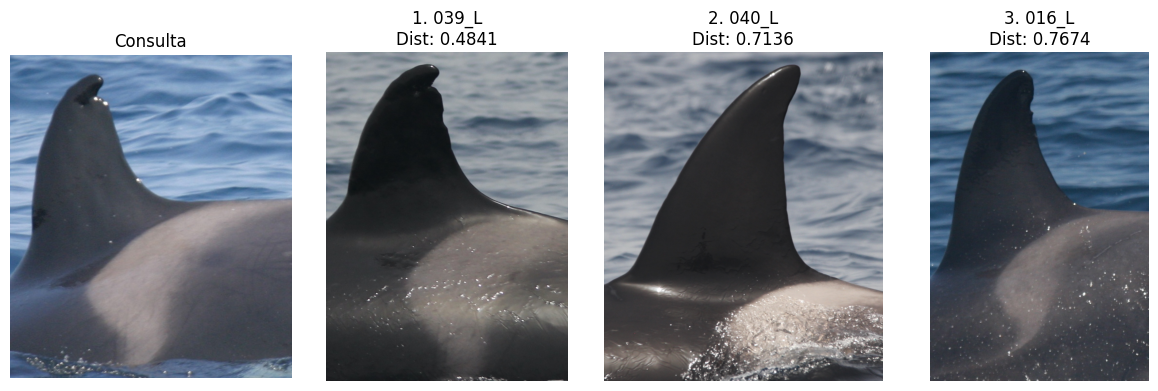

In [ ]:
# Rutas y parámetros
catalog_pkl_path = "/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_im.pkl"
query_image_path = "/content/drive/MyDrive/TFM/Orca/039_left.jpg"

# Ejecutar predicción
neighbors, distances = predict_with_dynamic_knn(
    image_path=query_image_path,
    model=model,                  # Tu modelo siamesa
    transform=transform,          # Tus transformaciones
    catalog_pkl_path=catalog_pkl_path,
    device=device,
    k=3,
    metric='euclidean'      #uso distancia euclídea
)


15. FUNCIÓN PARA CALCULAR PRECISIÓN TOP 1, TOP 3 Y TOP 5

In [ ]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
from PIL import Image
import os
import pickle
import numpy as np

def get_embedding(model, image_path, transform, device, use_cosine=False):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        embedding = model.forward_once(img_tensor).squeeze(0)
        embedding = F.normalize(embedding, p=2, dim=0) if use_cosine else embedding

    return embedding.cpu().numpy()

def calculate_topk_accuracy_siamese_knn(model, test_folder, catalog_pkl_path, transform, device, k_values=[1, 3, 5], metric='euclidean'):
    model.eval()

    # Cargar catálogo
    with open(catalog_pkl_path, 'rb') as f:
        catalog = pickle.load(f)

    class_ids = list(catalog.keys())
    embeddings = np.stack([catalog[c]['embedding'].numpy() for c in class_ids])

    # Inicializar KNN
    knn = NearestNeighbors(n_neighbors=max(k_values), metric=metric)
    knn.fit(embeddings)

    # Inicializar contadores
    correct_topk = {k: 0 for k in k_values}
    total = 0

    for individual in os.listdir(test_folder):
        individual_path = os.path.join(test_folder, individual)
        if not os.path.isdir(individual_path):
            continue

        image_files = [f for f in os.listdir(individual_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in image_files:
            img_path = os.path.join(individual_path, img_name)

            # Obtener embedding de la imagen de test
            query_emb = get_embedding(model, img_path, transform, device, use_cosine=(metric == 'cosine')).reshape(1, -1)

            # Buscar vecinos
            _, indices = knn.kneighbors(query_emb)

            # Obtener predicciones
            predicted_ids = [class_ids[i] for i in indices[0]]

            for k in k_values:
                if individual in predicted_ids[:k]:
                    correct_topk[k] += 1

            total += 1

    # Calcular precisión top-k
    accuracy_topk = {k: correct_topk[k] / total if total > 0 else 0.0 for k in k_values}
    return accuracy_topk


In [ ]:
#USO CALCULO PRECISIÓN TOP1, TOP3 Y TOP5 CON DATOS TEST

test_folder = "/content/drive/MyDrive/TFM/Cat_dataset/left_2/test"
catalog_pkl_path = "/content/drive/MyDrive/TFM/modelos2/avg_embeddings_left_contrast_im.pkl"

accuracy_topk = calculate_topk_accuracy_siamese_knn(
    model=model,
    test_folder=test_folder,
    catalog_pkl_path=catalog_pkl_path,
    transform=transform,
    device=device,
    k_values=[1, 3, 5],
    metric='euclidean'
)

# Mostrar resultados
for k, acc in accuracy_topk.items():
    print(f"Precisión Top-{k}: {acc * 100:.2f}%")


Precisión Top-1: 62.79%
Precisión Top-3: 74.42%
Precisión Top-5: 81.40%
